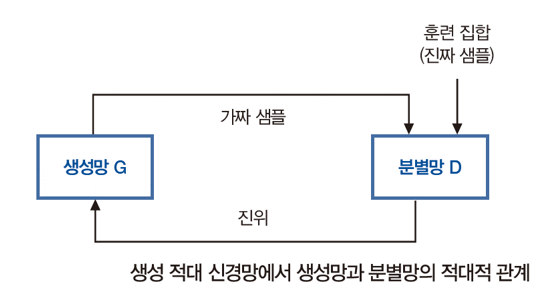

In [2]:
# 생성적대 신경망 
# GAN(generative adversarial network) : 2개의 신경망이 학습을 하는데. 서로 적대적인 관계에서 학습
# 개량--> ProGAN이 가장 뛰어남 - 이미지 디텍딩... 딥페이크를 구분하는 용도
# GAN의 학습 알고리즘
# G는 D를 속일수 있을 정도로 품질이 높은 가짜 샘플을 생성
# D는 G가 만든 가짜를 높은 정확률로 맞춤
# 위조지폐범과 경찰 --> 위조지폐범이 승리해야 만 함
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/86.PNG", width=500)

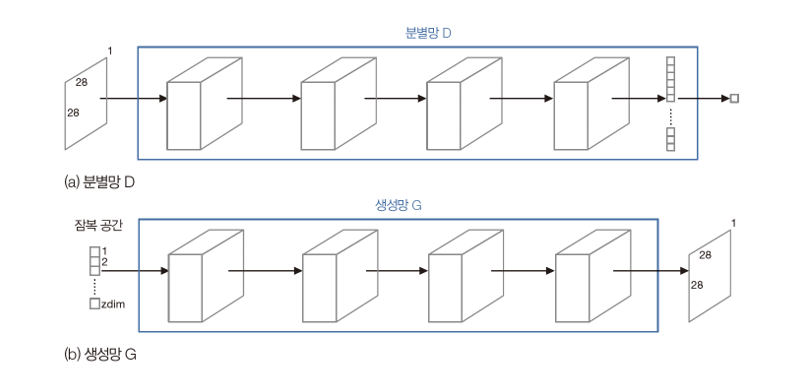

In [3]:
# MNIST로 적용
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/87.PNG", width=500)
# 분별망 D : 입력은 28*28영상, 출력노드1( 1 진짜 0가짜, 활성함수 : sigmoid)
# 생성망 G : 입력은 z-dim차원의 잠복공간의 한점의 좌표, 출력은 28*28영상 - 오토인코더와 비슷

# 학습
# 분별망은 이진분류 비교적 쉬움
# 생성망 학습 : 가짜샘플에 레이블 1을 붙여서 학습 즉 분별망을 속이는 행위
# 이때 가중치는 고정

In [4]:
# mnist를 이용한 적대 신경망
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense, Flatten,Reshape 
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Dropout,BatchNormalization,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k
from tensorflow.keras.losses import mse
import matplotlib.pylab as plt

In [10]:
# scaling.. -1 ~ 1
(x_train,y_train),(x_target,y_target) =  mnist.load_data()
x_train = (x_train/255.0)*2.0-1.0
x_target = (x_target/255.0)*2.0-1.0

x_train = x_train.reshape(-1,28,28,1)
x_target = x_target.reshape(-1,28,28,1)

# 하이퍼 파라메터
batch_size = 64
epochs = 5000
dropout_rate = 0.4
zdim = 100 #잠복공간의 차원
batchnormal = 0.9

In [11]:
# 분별망 D 설계
discriminator_input = Input(shape=(28,28,1))
x = Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x = Dropout(dropout_rate)(x)

x = Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
discriminator_output = Dense(1,activation='sigmoid')(x)     # 진짜(1)와 가짜(0)를 구별하려고 sigmoid를 사용
discriminator = Model(discriminator_input,discriminator_output) 
discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 64)          102464    
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 128)         204928    
                                                                 
 dropout_18 (Dropout)        (None, 4, 4, 128)         0   

In [18]:
# 생성망 G 설계
generate_input = Input(shape=(zdim,))
x = Dense(3136)(generate_input)
x=BatchNormalization(momentum=batchnormal)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)

x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batchnormal)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)

x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batchnormal)(x)
x=Activation('relu')(x)

x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batchnormal)(x)
x=Activation('relu')(x)

x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_ouput = x
generator = Model(generate_input,generator_ouput)
generator.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_9 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 3136)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 64)       0         
 2D)                                                       

In [19]:
# 생성망과 분별망의 학습
discriminator.compile(optimizer='Adam', loss='binary_crossentropy',metrics=(['accuracy']))

In [20]:
# 생성망의 학습 설정
discriminator.trainable = False
gan_input = Input(shape=(zdim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy', metrics=(['accuracy']))

In [22]:
# 분별망을 학습하는 함수
def train_discriminator(x_train):
    c = np.random.randint(0,x_train.shape[0],batch_size)
    real = x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_size,1)))   # 진짜 샘플에 레이블 1을 붙이고 학습
    
    p = np.random.normal(0,1,(batch_size,zdim))
    fake = generator.predict(p)
    discriminator.train_on_batch(fake,np.ones((batch_size,1)))   # 가짜 샘플에 레이블 0을 붙이고 학습

In [23]:
# 생성망을 학습하는 함수
def train_generator():
    p = np.random.normal(0,1,(batch_size,zdim))
    gan.train_on_batch(p,np.ones((batch_size,1)))

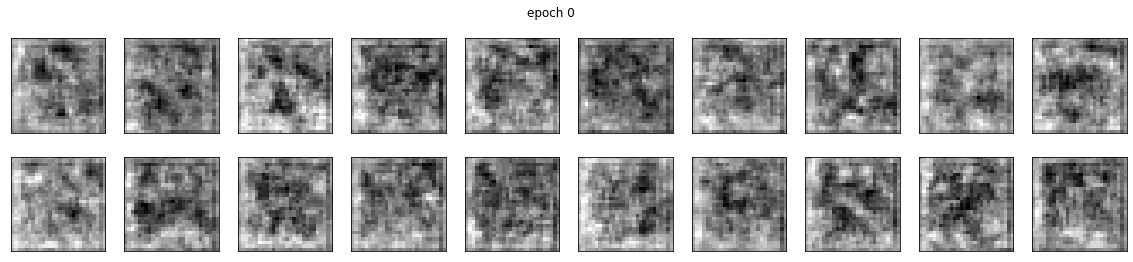

In [ ]:
# 학습을 수행
for i in range(epochs+1):
    train_discriminator(x_train)  # 분별망 학습
    train_generator()             # 생성망 학습
    if(i %100 ==0):               # 100 epoch(세대)마다 상황을 출력
        plt.figure(figsize=(20,4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img = generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()    